In [15]:
import os
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs import eeg_utils
from sklearn.model_selection import train_test_split
# Use these commands in the same cell to autoreload local library source code
# https://stackoverflow.com/questions/45807760/change-source-code-and-update-jupyter-notebook-but-retain-variables
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_subjects(basedir):
    files = np.array([i for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    subjects = np.array([i.split('_')[0] for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    return subjects, files

subjects, files = get_subjects("/mnt/nemar/child-mind-rest")
subj_train, subj_test, files_train, files_test = train_test_split(subjects, files, test_size=0.1, random_state=1)

subj_train, subj_val, files_train, files_val = train_test_split(subj_train, files_train, test_size=0.22, random_state=1) # 0.22 x 0.9 = 0.2

In [16]:
SFREQ = 128
dataset = MaskedContrastiveLearningDataset(
        data_dir = "/mnt/nemar/child-mind-rest",
        # subjects = subj_train.tolist(),
        n_subjects=10,
        x_params = {
            'window': 256
        },
    )

  0%|          | 0/10 [00:00<?, ?it/s]

/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:165: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  samples = np.stack(samples) # N x 2 (anchors, pos/neg) x C x W
 10%|█         | 1/10 [00:00<00:01,  4.57it/s]/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:165: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  samples = np.stack(samples) # N x 2 (anchors, pos/neg) x C x W
 20%|██        | 2/10 [00:00<00:01,  4.58it/s]/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:165: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  samples = np.stack(samples) # N x 2 (anchors, pos/neg) x C x W
/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:165: RuntimeWarning: The data contains 'bou

Data shape: (84, 128, 256)


Length of dataset 840
X dim (128, 256)
Creating RawArray with float64 data, n_channels=128, n_times=256
    Range : 0 ... 255 =      0.000 ...     1.992 secs
Ready.


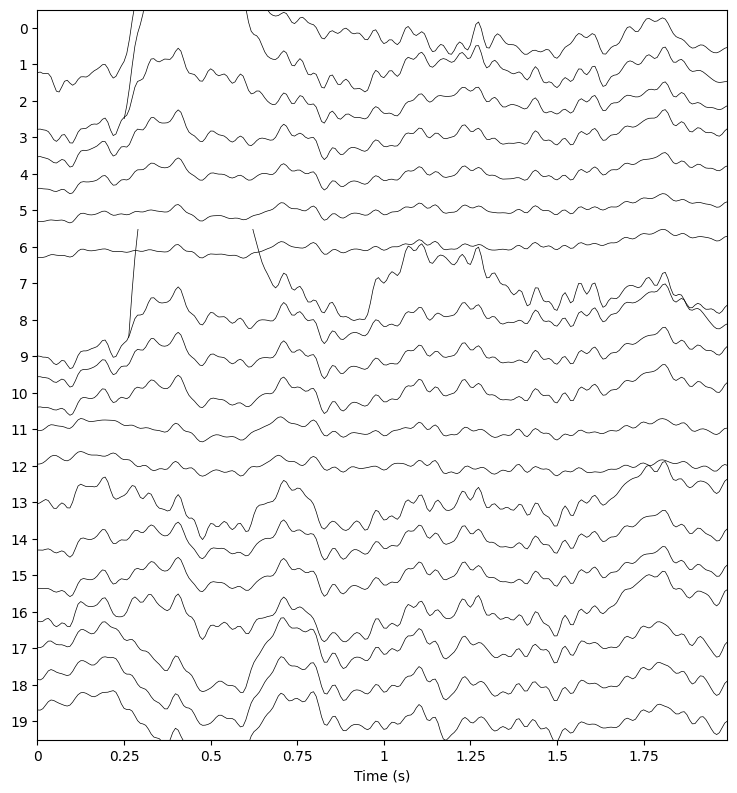

In [17]:
print('Length of dataset', len(dataset))
print('X dim', dataset[0].shape)
eeg_utils.plot_raw_eeg(dataset[0])

In [6]:
model = Wav2VecBrainModel()
task = MaskedContrastiveLearningTask()
trained_model = task.train(model, dataset)

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch 0, Iteration 0, loss = 3.2582
Epoch 0, Iteration 10, loss = 3.2593
Epoch 0, Iteration 20, loss = 3.2582
Epoch 0, Iteration 30, loss = 3.2583
Epoch 0, Iteration 40, loss = 3.2590
Epoch 0, Iteration 50, loss = 3.2598
Epoch 0, Iteration 60, loss = 3.2585
Epoch 0, Iteration 70, loss = 3.2582
Epoch 0, Iteration 80, loss = 3.2581
Epoch 0, Iteration 90, loss = 3.2580
Epoch 0, Iteration 100, loss = 3.2582
Epoch 1, Iteration 0, loss = 3.2581
Epoch 1, Iteration 10, loss = 3.2581
Epoch 1, Iteration 20, loss = 3.3079
Epoch 1, Iteration 30, loss = nan
Epoch 1, Iteration 40, loss = nan
Epoch 1, Iteration 50, loss = nan
Epoch 1, Iteration 60, loss = nan
Epoch 1, Iteration 70, loss = nan
Epoch 1, Iteration 80, loss = nan
Epoch 1, Iteration 90, loss = nan
Epoch 1, Iteration 100, loss = nan
Epoch 2, Iteration 0, loss = nan
Epoch 2, Iteration 10, loss = nan
Epoch 2, Iteration 20, loss = nan
Epoch 2, Iteration 30, loss = nan
Epoch 2, Iteration 40, loss = nan
Epoch 2, Iteration 50, loss = nan
Epoch 2

Traceback (most recent call last):
  File "/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1864729/3620024241.py", line 3, in <module>
    trained_model = task.train(model, dataset)
  File "/home/dung/eeg-ssl/notebooks/../libs/ssl_utils.py", line 357, in train
  File "/home/dung/eeg-ssl/notebooks/../libs/ssl_utils.py", line 306, in forward
    @return
  File "/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/dung/eeg-ssl/notebooks/../libs/ssl_model.py", line 106, in forward
    x = self.attention[i](x, x, x)[0]
  File "/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages